In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

import wrangle

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

# Using Time Series Analysis To Predict Cryptocurrency Price Changes

Lori Ainslie, 1/24/22

<hr style="border:2px solid blue"> </hr>

# Executive Summary

## Project Goals

* To use time series analysis to analyze cryptocurrency prices and develop a model that can predict changes in prices.

## Project Description

* Cryptocurrency is a massive and growing industry that provides incredible opportunity for profit but also comes with risk of loss due to its volatility. With models that can identify trends and predict upcoming price changes, these risks can be mitigated.


* The cryptocurrency used in this analysis **~~are HOLO (HOT1-USD) and~~** NEM (XEM-USD). Both have a little over $1B market capitalization at the time of this report. The closing price is what I will be predicting.

<hr style="border:2px solid blue"> </hr>

# Acquisition & Preparation

In [3]:
# use a function to pull in, clean, and split cryptocurrency price data.
cryptocurrency = wrangle.prep_crypto_data()
nem_train, nem_validate, nem_test = pd.DataFrame(cryptocurrency[0][0]),\
                                    pd.DataFrame(cryptocurrency[0][1]),\
                                    pd.DataFrame(cryptocurrency[0][2])

**Steps taken to prepare the data:**

* Became familiar with data (column names, data types, # of observations & features, checked null values, statistical information, and value counts)


* Removed all columns other than target variable (cryptocurrency Close price)


* Data did not have any null values and columns were the correct datatypes


* Used a histogram to check out distribution of Close values


* Created functions to clean and split the data

<hr style="border:2px solid blue"> </hr>

# Exploration

## 1. What trends can we see in the data? Is there a seasonality component?

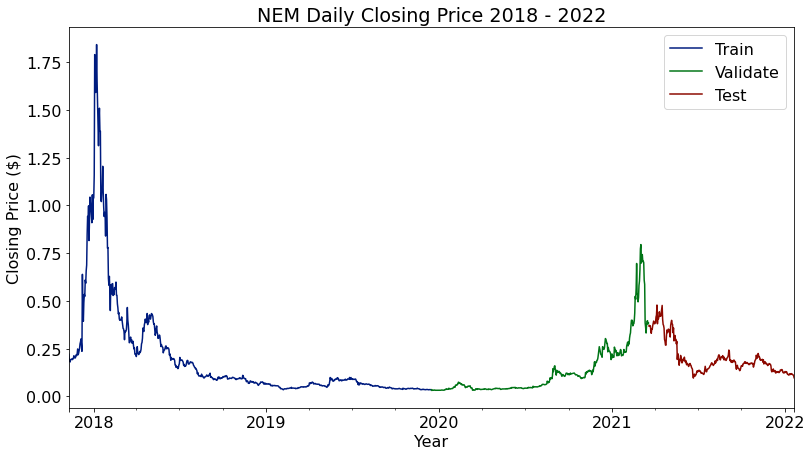

In [4]:
ax = nem_train.plot(label='Train')
nem_validate.plot(ax=ax, label='Validate')
nem_test.plot(ax=ax, label='Test')
ax.set(title='NEM Daily Closing Price 2018 - 2022', xlabel='Year', ylabel='Closing Price ($)')
plt.legend(['Train', 'Validate', 'Test']);

### It appears NEM has stayed fairly steady over the years other than a spike in price during 2018 and 2021 that both dropped back down. There is no evidence of seasonality in the data.

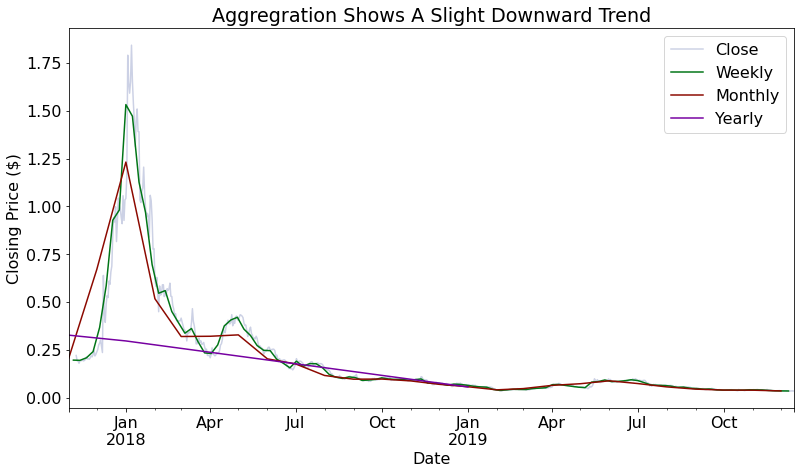

In [5]:
# resample, aggregate, and visualize over various time periods
ax = nem_train.plot(alpha=.2, label='Daily')
nem_train.resample('W').Close.mean().plot(ax=ax, label='Weekly')
nem_train.resample('M').Close.mean().plot(ax=ax, label='Monthly')
nem_train.resample('Y').Close.mean().plot(ax=ax, label='Yearly')
ax.set(title='Aggregration Shows A Slight Downward Trend', xlabel='Date', ylabel='Closing Price ($)', 
       xlim=(pd.Timestamp('2017-11-01'), pd.Timestamp('2019-12-15')))
plt.legend();

### If we focus only on the training dataset and aggregate, therefore smoothing out some of the price movements, we can see a slight downward trend in the data.

***

## 2. Are there any months we can identify as having significantly higher or lower closing prices?

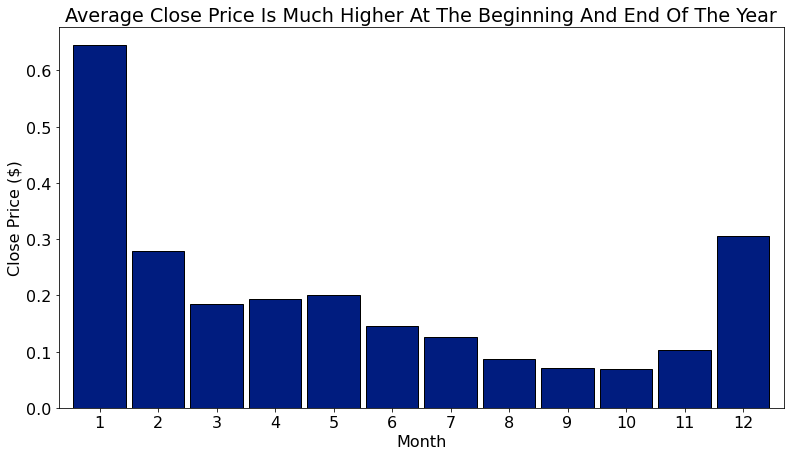

In [6]:
# plot average close price by month for NEM
ax = nem_train.groupby(nem_train.index.month).Close.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Close Price Is Much Higher At The Beginning And End Of The Year', xlabel='Month', ylabel='Close Price ($)');

### Grouping by year shows that it could be beneficial to buy NEM cryptocurrency around October and sell during January when prices are highest. This chart, however, is only based on two years' of data and the initial chart showing closing price over the years does not show clear evidence to support this, so I would gather more data before basing any decisions on this result.

***

## 3. Are there any days of the week we can identify as having significantly higher or lower closing prices?

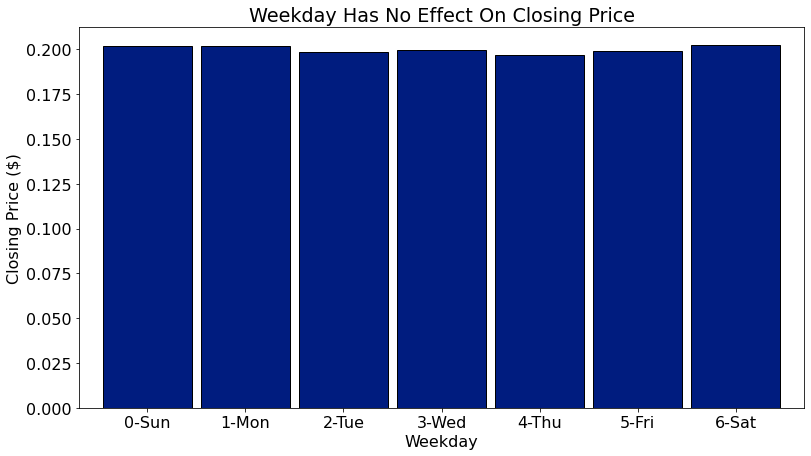

In [7]:
# plot average close price by weekday for NEM
ax = nem_train.groupby(nem_train.index.strftime('%w-%a')).Close.mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Weekday Has No Effect On Closing Price', xlabel='Weekday', ylabel='Closing Price ($)');

### Cryptocurrency markets are open 24/7 which could explain why there is not much variation in average closing price by day of the week. Weekday is not a good indicator of price changes.

***

## Exploration Summary

### - Charts show that NEM cryptocurrency closing prices do not have much seasonality or patterns that can make it easy to predict changes.


### - Due to the relatively steady price other than a few spikes, an autoregressive model based on recent prices is likely the best predictor of price changes.

<hr style="border:2px solid blue"> </hr>

# Modeling

### Establish a baseline 

* The baseline will be the simple average of the train dataset which will be used to make predictions. 
* The root mean square error (RMSE) will be the metric used to evaluate the models. 
* To be of value, any other models will need to beat the RMSE of the baseline model.

In [8]:
# create df object to append evaluation metrics to
eval_df = pd.DataFrame(columns=['model', 'rmse'])

Baseline Prediction  = 0.2
Baseline Prediction RMSE: 0.1587


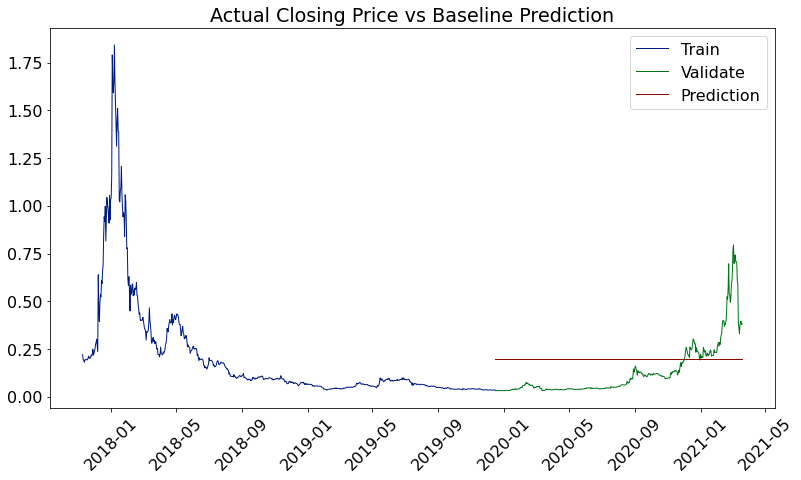

In [9]:
# use function to predict using mean of train closing data and plot actual vs predicted
eval_df = wrangle.predict_evaluate_baseline(nem_train, nem_validate, eval_df)

### Predict And Evaluate Using Moving Average
* The prediction will be made using the last/most recent value after calculating the 30-day rolling average for the train dataset. 

1-Year Moving Avg  = 0.05698
1-Year Moving Avg RMSE: 0.16129


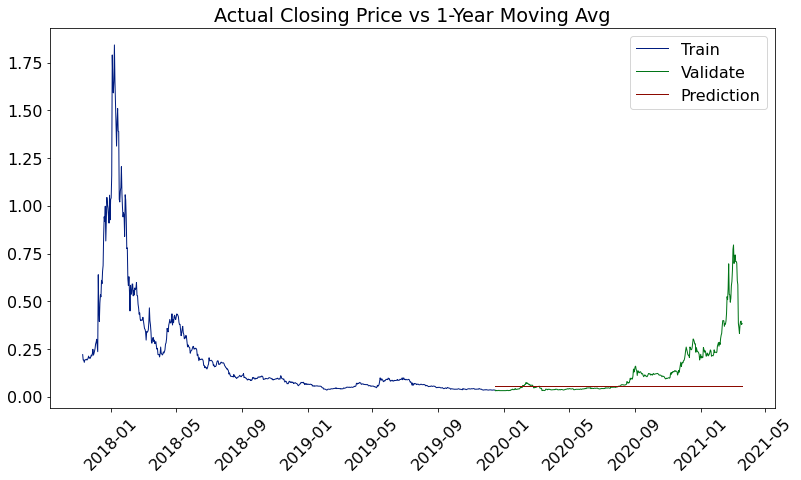

In [10]:
# use function to predict using most recent 30-day moving avg and plot actual vs predicted
eval_df = wrangle.predict_evaluate_1yr_mavg(nem_train, nem_validate, eval_df)

### Predict And Evaluate Using Holt's Linear Trend

Holt's Linear Trend RMSE: 0.13713


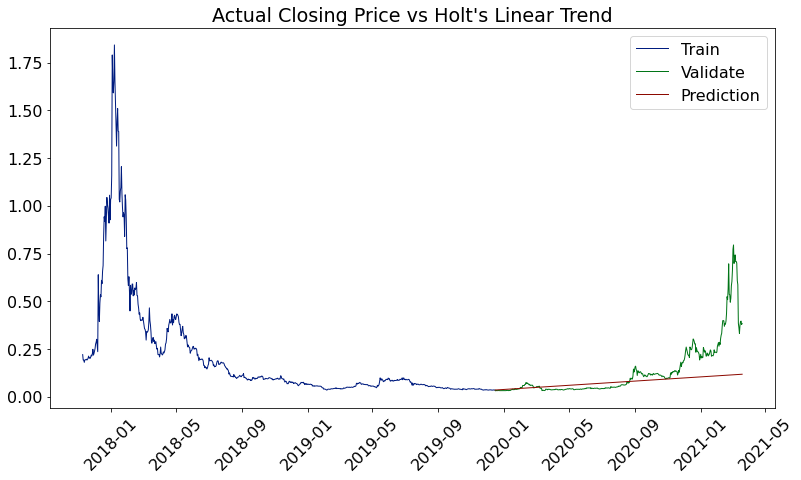

In [12]:
# use function to predict using Holt's Linear Trend and plot actual vs predicted
eval_df = wrangle.predict_evaluate_holts_linear(nem_train, nem_validate, eval_df)

### Predict And Evaluate Using AutoRegressive Integrated Moving Average  (ARIMA)

ARIMA RMSE: 0.13104


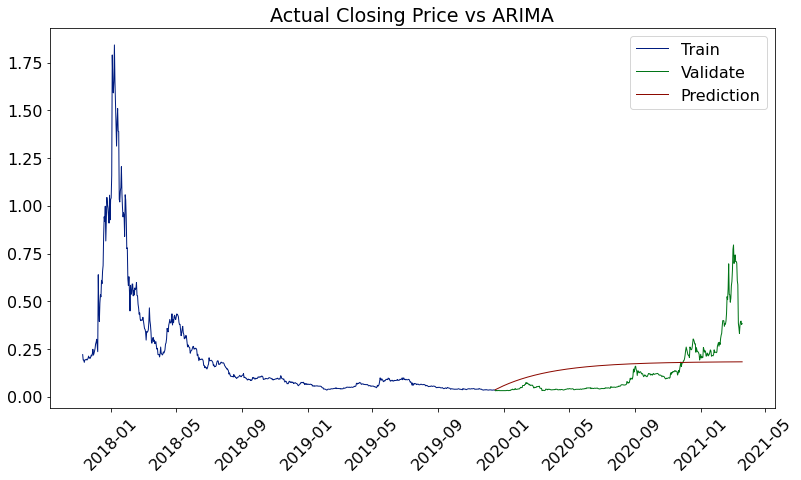

In [14]:
# use function to predict using ARIMA and plot actual vs predicted
eval_df = wrangle.predict_evaluate_arima(nem_train, nem_validate, eval_df)

In [17]:
# show metrics
eval_df

,model,rmse
0,Baseline Prediction,0.15870
1,1-Year Moving Avg,0.16129
2,Holt's Linear Trend,0.13713
3,ARIMA,0.13104


### Predict And Evaluate Test Dataset Using Best Performing Model

# Conclusion


## Summary

The goal of this project was:

* To use time series analysis to analyze cryptocurrency prices and develop a model that can predict changes in prices.

I identified some of the drivers of property tax value as:

* Area

* Bathrooms

* Bedrooms

I built a model that is expected to perform with an RMSE of about $101,000 on unseen data.


## Recommendations

- Improve methods of data collection so that features that were not used because of null values may be implemented


## Next Steps

- With more time and resources, I would like to conduct more feature engineering and explore the relationships between property tax value and features which initially may not seem important